In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Section 1 – Setup & imports

In [1]:
import os, sys, random, math, time, gc
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

try:
    import albumentations as A
except Exception:
    !pip install -q albumentations
    import albumentations as A

try:
    import timm
except Exception:
    !pip install -q timm
    import timm

print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Torch: 2.6.0+cu124
Device: cuda


# Section 2 – Dataset loading & binary labels

In [2]:
dataset_path = "/kaggle/input/brain-stroke-ct-dataset/Brain_Stroke_CT_Dataset"

orig_classes = ["Normal", "Bleeding", "Ischemia"]
binary_map = {"Normal": 0, "Bleeding": 1, "Ischemia": 1}

rows = []
for cls in orig_classes:
    img_dir = os.path.join(dataset_path, cls, "PNG")
    if not os.path.isdir(img_dir):
        print(f"[WARN] Missing directory: {img_dir}")
        continue
    for fname in os.listdir(img_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            rows.append({
                "path": os.path.join(img_dir, fname),
                "orig_label": cls,
                "label": binary_map[cls]
            })

df = pd.DataFrame(rows)
print("Total images:", len(df))
print("\nOriginal label counts:")
print(df["orig_label"].value_counts())
print("\nBinary label counts (0=Normal, 1=Abnormal):")
print(df["label"].value_counts())

df_normal = df[df["label"] == 0]
df_abnormal = df[df["label"] == 1]

n_normal = len(df_normal)
n_abnormal = len(df_abnormal)

# Oversample minority to balance
if n_abnormal < n_normal:
    df_abnormal_up = df_abnormal.sample(
        n=n_normal,
        replace=True,
        random_state=42
    )
    df_balanced = pd.concat([df_normal, df_abnormal_up], axis=0)
else:
    df_normal_up = df_normal.sample(
        n=n_abnormal,
        replace=True,
        random_state=42
    )
    df_balanced = pd.concat([df_normal_up, df_abnormal], axis=0)

df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\nAfter oversampling:")
print(df_balanced["label"].value_counts())

train_df, holdout_df = train_test_split(
    df_balanced,
    test_size=0.10,
    stratify=df_balanced["label"],
    random_state=42
)

print("\nTrain size:", len(train_df), "Holdout size:", len(holdout_df))
print("Train label counts:\n", train_df["label"].value_counts())
print("Holdout label counts:\n", holdout_df["label"].value_counts())


Total images: 6650

Original label counts:
orig_label
Normal      4427
Ischemia    1130
Bleeding    1093
Name: count, dtype: int64

Binary label counts (0=Normal, 1=Abnormal):
label
0    4427
1    2223
Name: count, dtype: int64

After oversampling:
label
0    4427
1    4427
Name: count, dtype: int64

Train size: 7968 Holdout size: 886
Train label counts:
 label
0    3984
1    3984
Name: count, dtype: int64
Holdout label counts:
 label
1    443
0    443
Name: count, dtype: int64


# Section 3 – Augmentations & Dataset (shared)

In [4]:
IMG_SIZE = 384

train_aug = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.07,
        scale_limit=0.12,
        rotate_limit=10,
        border_mode=cv2.BORDER_REFLECT_101,
        p=0.7
    ),
    A.OneOf([
        A.RandomBrightnessContrast(limit=0.25),
        A.CLAHE(clip_limit=3.0),
        A.RandomGamma(gamma_limit=(80, 120)),
    ], p=0.8),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.4),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.Normalize()
])

val_aug = A.Compose([
    A.Normalize()
])

class CTBinaryDataset(Dataset):
    def __init__(self, df, mode="train"):
        self.df = df.reset_index(drop=True)
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        label = int(row["label"])

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to read image: {path}")

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        if self.mode == "train":
            augmented = train_aug(image=img)
        else:
            augmented = val_aug(image=img)

        img = augmented["image"]
        img = np.stack([img, img, img], axis=-1)  # H,W,3
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))      # C,H,W

        return torch.tensor(img), torch.tensor(label, dtype=torch.long)

tmp_ds = CTBinaryDataset(train_df.sample(8), mode="train")
tmp_loader = DataLoader(tmp_ds, batch_size=4, shuffle=True)
imgs, labels = next(iter(tmp_loader))
print("Batch shape:", imgs.shape, "Labels:", labels)


Batch shape: torch.Size([4, 3, 384, 384]) Labels: tensor([0, 1, 0, 0])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_47/509745677.py:15: UserWarning: Argument(s) 'limit' are not valid for transform RandomBrightnessContrast
  A.RandomBrightnessContrast(limit=0.25),
/tmp/ipykernel_47/509745677.py:19: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0), p=0.4),


# Section 4 – Model, loss, helper functions

In [5]:
def create_model(backbone_name="tf_efficientnet_b3_ns", pretrained=True, n_classes=1):
    backbone = timm.create_model(
        backbone_name,
        pretrained=pretrained,
        num_classes=0,
        global_pool="avg"
    )
    in_features = backbone.num_features
    head = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, n_classes)
    )
    model = nn.Sequential(backbone, head)
    return model

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.35, gamma=2.5, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, logits, targets):
        targets = targets.float().unsqueeze(1)
        bce_loss = self.bce(logits, targets)
        prob = torch.sigmoid(logits)
        p_t = prob * targets + (1 - prob) * (1 - targets)
        alpha_factor = targets * self.alpha + (1 - targets) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss = alpha_factor * modulating_factor * bce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

def preds_from_logits(logits):
    probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
    return probs

def labels_from_probs(probs, thresh=0.5):
    return (probs > thresh).astype(int)

def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(imgs)
            if logits.ndim > 2:
                logits = logits.view(-1, 1)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)

        probs = preds_from_logits(logits)
        all_preds.append(probs)
        all_targets.append(labels.cpu().numpy().ravel())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    avg_loss = running_loss / len(loader.dataset)
    acc = (labels_from_probs(all_preds) == all_targets).mean()

    return avg_loss, acc, all_targets, all_preds

def evaluate_epoch(model, loader, criterion=None):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast():
                logits = model(imgs)
                if logits.ndim > 2:
                    logits = logits.view(-1, 1)

                if criterion is not None:
                    loss = criterion(logits, labels)
                    running_loss += loss.item() * imgs.size(0)

            probs = preds_from_logits(logits)
            all_preds.append(probs)
            all_targets.append(labels.cpu().numpy().ravel())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    avg_loss = running_loss / len(loader.dataset) if criterion is not None else None
    acc = (labels_from_probs(all_preds) == all_targets).mean()

    return avg_loss, acc, all_targets, all_preds


# Section 5 – Stratified K-Fold training + HNM

In [6]:
n_folds = 5
epochs = 14
hnm_epoch = 6
batch_size = 32
head_lr = 1e-4
backbone_lr = 1e-5
weight_decay = 1e-5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))
oof_targets = train_df["label"].values

fold_idx = 0

for tr_idx, vl_idx in skf.split(train_df, train_df["label"]):
    fold_idx += 1
    print(f"\n================ Fold {fold_idx}/{n_folds} ================")

    tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
    vl_df = train_df.iloc[vl_idx].reset_index(drop=True)

    def make_loaders(tr_df_local):
        train_ds = CTBinaryDataset(tr_df_local, mode="train")
        val_ds = CTBinaryDataset(vl_df, mode="val")

        class_counts = tr_df_local["label"].value_counts().to_dict()
        sample_weights = tr_df_local["label"].apply(
            lambda x: 1.0 / class_counts[x]
        ).values

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=4,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        return train_loader, val_loader

    train_loader, val_loader = make_loaders(tr_df)

    model = create_model("tf_efficientnet_b3_ns", pretrained=True, n_classes=1).to(device)

    for p in model[0].parameters():
        p.requires_grad = False

    optimizer = optim.Adam(
        [{"params": model[1].parameters(), "lr": head_lr}],
        lr=head_lr,
        weight_decay=weight_decay
    )
    scaler = GradScaler()
    criterion = FocalLoss(alpha=0.35, gamma=2.5).to(device)

    best_val_acc = 0.0
    best_path = f"best_fold_{fold_idx}.pth"

    for epoch in range(1, epochs + 1):
        print(f"\nFold {fold_idx} - Epoch {epoch}/{epochs}")

        if epoch == 3:
            for p in model[0].parameters():
                p.requires_grad = True
            optimizer = optim.Adam(
                [
                    {"params": model[0].parameters(), "lr": backbone_lr},
                    {"params": model[1].parameters(), "lr": head_lr}
                ],
                lr=head_lr,
                weight_decay=weight_decay
            )
            print("Backbone unfrozen.")

        tr_loss, tr_acc, _, _ = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
        val_loss, val_acc, v_targets, v_probs = evaluate_epoch(model, val_loader, criterion)

        print(f"Train loss: {tr_loss:.4f} | acc: {tr_acc:.4f}")
        print(f"Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_path)
            print(f"New best model saved: {best_path} (val_acc={best_val_acc:.4f})")

        # Hard Negative Mining
        if epoch == hnm_epoch:
            print("\n[HNM] Running hard negative mining on current training set...")
            tr_eval_ds = CTBinaryDataset(tr_df, mode="val")
            tr_eval_loader = DataLoader(
                tr_eval_ds, batch_size=batch_size,
                shuffle=False, num_workers=4, pin_memory=True
            )

            _, tr_eval_acc, tr_targets, tr_probs = evaluate_epoch(model, tr_eval_loader, criterion=None)
            tr_pred_labels = labels_from_probs(tr_probs)

            hard_idx = np.where((tr_targets == 1) & (tr_pred_labels == 0))[0]
            print(f"[HNM] Found {len(hard_idx)} hard negatives in fold {fold_idx} (Abnormal→Normal).")

            if len(hard_idx) > 0:
                hard_samples = tr_df.iloc[hard_idx].copy()
                tr_df = pd.concat([tr_df, hard_samples, hard_samples], axis=0)
                tr_df = tr_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
                print(f"[HNM] Training set size after HNM: {len(tr_df)}")
                train_loader, val_loader = make_loaders(tr_df)
            else:
                print("[HNM] No hard negatives found; skipping augmentation.")

    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()

    val_ds_full = CTBinaryDataset(vl_df, mode="val")
    val_loader_full = DataLoader(
        val_ds_full,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    fold_preds = []
    with torch.no_grad():
        for imgs, _ in val_loader_full:
            imgs = imgs.to(device)
            with autocast():
                logits = model(imgs)
                if logits.ndim > 2:
                    logits = logits.view(-1, 1)
                probs = preds_from_logits(logits)
            fold_preds.append(probs)

    fold_preds = np.concatenate(fold_preds)
    oof_preds[vl_idx] = fold_preds

    print(f"\nFold {fold_idx} completed. Best val accuracy: {best_val_acc:.4f}")



================ Fold 1/5 ================


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Fold 1 - Epoch 1/14


/tmp/ipykernel_47/3476614341.py:68: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_47/4086465304.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val:   0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_47/4086465304.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train loss: 0.0531 | acc: 0.5952
Val   loss: 0.0445 | acc: 0.7077
New best model saved: best_fold_1.pth (val_acc=0.7077)

Fold 1 - Epoch 2/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0481 | acc: 0.6763
Val   loss: 0.0411 | acc: 0.7415
New best model saved: best_fold_1.pth (val_acc=0.7415)

Fold 1 - Epoch 3/14
Backbone unfrozen.


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0443 | acc: 0.7173
Val   loss: 0.0328 | acc: 0.8030
New best model saved: best_fold_1.pth (val_acc=0.8030)

Fold 1 - Epoch 4/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0395 | acc: 0.7615
Val   loss: 0.0284 | acc: 0.8325
New best model saved: best_fold_1.pth (val_acc=0.8325)

Fold 1 - Epoch 5/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0365 | acc: 0.7882
Val   loss: 0.0261 | acc: 0.8457
New best model saved: best_fold_1.pth (val_acc=0.8457)

Fold 1 - Epoch 6/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0330 | acc: 0.8164
Val   loss: 0.0222 | acc: 0.8701
New best model saved: best_fold_1.pth (val_acc=0.8701)

[HNM] Running hard negative mining on current training set...


Val:   0%|          | 0/200 [00:00<?, ?it/s]

[HNM] Found 696 hard negatives in fold 1 (Abnormal→Normal).
[HNM] Training set size after HNM: 7766

Fold 1 - Epoch 7/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0367 | acc: 0.7852
Val   loss: 0.0203 | acc: 0.8927
New best model saved: best_fold_1.pth (val_acc=0.8927)

Fold 1 - Epoch 8/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0351 | acc: 0.7951
Val   loss: 0.0180 | acc: 0.9235
New best model saved: best_fold_1.pth (val_acc=0.9235)

Fold 1 - Epoch 9/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0331 | acc: 0.8089
Val   loss: 0.0167 | acc: 0.9404
New best model saved: best_fold_1.pth (val_acc=0.9404)

Fold 1 - Epoch 10/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0313 | acc: 0.8199
Val   loss: 0.0153 | acc: 0.9479
New best model saved: best_fold_1.pth (val_acc=0.9479)

Fold 1 - Epoch 11/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0306 | acc: 0.8273
Val   loss: 0.0131 | acc: 0.9479

Fold 1 - Epoch 12/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0298 | acc: 0.8287
Val   loss: 0.0121 | acc: 0.9567
New best model saved: best_fold_1.pth (val_acc=0.9567)

Fold 1 - Epoch 13/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0277 | acc: 0.8474
Val   loss: 0.0111 | acc: 0.9523

Fold 1 - Epoch 14/14


Train:   0%|          | 0/243 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0263 | acc: 0.8514
Val   loss: 0.0109 | acc: 0.9605
New best model saved: best_fold_1.pth (val_acc=0.9605)


/tmp/ipykernel_47/3476614341.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Fold 1 completed. Best val accuracy: 0.9605

================ Fold 2/5 ================

Fold 2 - Epoch 1/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0529 | acc: 0.5940
Val   loss: 0.0434 | acc: 0.7327
New best model saved: best_fold_2.pth (val_acc=0.7327)

Fold 2 - Epoch 2/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80><function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, i

Train loss: 0.0479 | acc: 0.6759
Val   loss: 0.0437 | acc: 0.6888

Fold 2 - Epoch 3/14
Backbone unfrozen.


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0436 | acc: 0.7214
Val   loss: 0.0347 | acc: 0.7886
New best model saved: best_fold_2.pth (val_acc=0.7886)

Fold 2 - Epoch 4/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0402 | acc: 0.7491
Val   loss: 0.0292 | acc: 0.8363
New best model saved: best_fold_2.pth (val_acc=0.8363)

Fold 2 - Epoch 5/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0368 | acc: 0.7851
Val   loss: 0.0265 | acc: 0.8457
New best model saved: best_fold_2.pth (val_acc=0.8457)

Fold 2 - Epoch 6/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0346 | acc: 0.8008
Val   loss: 0.0251 | acc: 0.8557
New best model saved: best_fold_2.pth (val_acc=0.8557)

[HNM] Running hard negative mining on current training set...


Val:   0%|          | 0/200 [00:00<?, ?it/s]

[HNM] Found 718 hard negatives in fold 2 (Abnormal→Normal).
[HNM] Training set size after HNM: 7810

Fold 2 - Epoch 7/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0375 | acc: 0.7776
Val   loss: 0.0241 | acc: 0.8726
New best model saved: best_fold_2.pth (val_acc=0.8726)

Fold 2 - Epoch 8/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0344 | acc: 0.7974
Val   loss: 0.0216 | acc: 0.8808
New best model saved: best_fold_2.pth (val_acc=0.8808)

Fold 2 - Epoch 9/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>    
Traceback (most recent call last):
if w.is_alive():
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      ^^if w.is_alive():
^^ ^^ ^  ^^^   ^^^^
^      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ ^^^
   File "/usr/lib/py

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0330 | acc: 0.8101
Val   loss: 0.0188 | acc: 0.9241
New best model saved: best_fold_2.pth (val_acc=0.9241)

Fold 2 - Epoch 10/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0320 | acc: 0.8149
Val   loss: 0.0180 | acc: 0.9003

Fold 2 - Epoch 11/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0301 | acc: 0.8262
Val   loss: 0.0163 | acc: 0.9166

Fold 2 - Epoch 12/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0283 | acc: 0.8394
Val   loss: 0.0171 | acc: 0.9184

Fold 2 - Epoch 13/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0278 | acc: 0.8456
Val   loss: 0.0136 | acc: 0.9511
New best model saved: best_fold_2.pth (val_acc=0.9511)

Fold 2 - Epoch 14/14


Train:   0%|          | 0/245 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0264 | acc: 0.8545
Val   loss: 0.0126 | acc: 0.9454

Fold 2 completed. Best val accuracy: 0.9511

================ Fold 3/5 ================

Fold 3 - Epoch 1/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0526 | acc: 0.5924
Val   loss: 0.0450 | acc: 0.6826
New best model saved: best_fold_3.pth (val_acc=0.6826)

Fold 3 - Epoch 2/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0473 | acc: 0.6845
Val   loss: 0.0408 | acc: 0.7340
New best model saved: best_fold_3.pth (val_acc=0.7340)

Fold 3 - Epoch 3/14
Backbone unfrozen.


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0426 | acc: 0.7264
Val   loss: 0.0356 | acc: 0.7811
New best model saved: best_fold_3.pth (val_acc=0.7811)

Fold 3 - Epoch 4/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0388 | acc: 0.7673
Val   loss: 0.0285 | acc: 0.8256
New best model saved: best_fold_3.pth (val_acc=0.8256)

Fold 3 - Epoch 5/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0365 | acc: 0.7943
Val   loss: 0.0292 | acc: 0.8112

Fold 3 - Epoch 6/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0350 | acc: 0.7973
Val   loss: 0.0243 | acc: 0.8582
New best model saved: best_fold_3.pth (val_acc=0.8582)

[HNM] Running hard negative mining on current training set...


Val:   0%|          | 0/200 [00:00<?, ?it/s]

[HNM] Found 714 hard negatives in fold 3 (Abnormal→Normal).
[HNM] Training set size after HNM: 7802

Fold 3 - Epoch 7/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0375 | acc: 0.7742
Val   loss: 0.0219 | acc: 0.8795
New best model saved: best_fold_3.pth (val_acc=0.8795)

Fold 3 - Epoch 8/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0356 | acc: 0.7931
Val   loss: 0.0184 | acc: 0.9122
New best model saved: best_fold_3.pth (val_acc=0.9122)

Fold 3 - Epoch 9/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0339 | acc: 0.7965
Val   loss: 0.0170 | acc: 0.9222
New best model saved: best_fold_3.pth (val_acc=0.9222)

Fold 3 - Epoch 10/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0316 | acc: 0.8138
Val   loss: 0.0161 | acc: 0.9373
New best model saved: best_fold_3.pth (val_acc=0.9373)

Fold 3 - Epoch 11/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0297 | acc: 0.8336
Val   loss: 0.0145 | acc: 0.9329

Fold 3 - Epoch 12/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0284 | acc: 0.8464
Val   loss: 0.0137 | acc: 0.9435
New best model saved: best_fold_3.pth (val_acc=0.9435)

Fold 3 - Epoch 13/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0269 | acc: 0.8484
Val   loss: 0.0117 | acc: 0.9511
New best model saved: best_fold_3.pth (val_acc=0.9511)

Fold 3 - Epoch 14/14


Train:   0%|          | 0/244 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0273 | acc: 0.8398
Val   loss: 0.0109 | acc: 0.9586
New best model saved: best_fold_3.pth (val_acc=0.9586)

Fold 3 completed. Best val accuracy: 0.9586

================ Fold 4/5 ================

Fold 4 - Epoch 1/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0525 | acc: 0.5967
Val   loss: 0.0433 | acc: 0.7207
New best model saved: best_fold_4.pth (val_acc=0.7207)

Fold 4 - Epoch 2/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0477 | acc: 0.6794
Val   loss: 0.0395 | acc: 0.7652
New best model saved: best_fold_4.pth (val_acc=0.7652)

Fold 4 - Epoch 3/14
Backbone unfrozen.


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0445 | acc: 0.7180
Val   loss: 0.0324 | acc: 0.8123
New best model saved: best_fold_4.pth (val_acc=0.8123)

Fold 4 - Epoch 4/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0401 | acc: 0.7529
Val   loss: 0.0284 | acc: 0.8456
New best model saved: best_fold_4.pth (val_acc=0.8456)

Fold 4 - Epoch 5/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0366 | acc: 0.7870
Val   loss: 0.0249 | acc: 0.8606
New best model saved: best_fold_4.pth (val_acc=0.8606)

Fold 4 - Epoch 6/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0342 | acc: 0.8044
Val   loss: 0.0223 | acc: 0.8870
New best model saved: best_fold_4.pth (val_acc=0.8870)

[HNM] Running hard negative mining on current training set...


Val:   0%|          | 0/200 [00:00<?, ?it/s]

[HNM] Found 552 hard negatives in fold 4 (Abnormal→Normal).
[HNM] Training set size after HNM: 7479

Fold 4 - Epoch 7/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0372 | acc: 0.7787
Val   loss: 0.0204 | acc: 0.9102
New best model saved: best_fold_4.pth (val_acc=0.9102)

Fold 4 - Epoch 8/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0350 | acc: 0.7978
Val   loss: 0.0189 | acc: 0.9266
New best model saved: best_fold_4.pth (val_acc=0.9266)

Fold 4 - Epoch 9/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0331 | acc: 0.8136
Val   loss: 0.0173 | acc: 0.9316
New best model saved: best_fold_4.pth (val_acc=0.9316)

Fold 4 - Epoch 10/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0310 | acc: 0.8240
Val   loss: 0.0155 | acc: 0.9322
New best model saved: best_fold_4.pth (val_acc=0.9322)

Fold 4 - Epoch 11/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0297 | acc: 0.8317
Val   loss: 0.0153 | acc: 0.9460
New best model saved: best_fold_4.pth (val_acc=0.9460)

Fold 4 - Epoch 12/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0288 | acc: 0.8385
Val   loss: 0.0158 | acc: 0.9140

Fold 4 - Epoch 13/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0283 | acc: 0.8397
Val   loss: 0.0140 | acc: 0.9466
New best model saved: best_fold_4.pth (val_acc=0.9466)

Fold 4 - Epoch 14/14


Train:   0%|          | 0/234 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0268 | acc: 0.8523
Val   loss: 0.0130 | acc: 0.9454

Fold 4 completed. Best val accuracy: 0.9466

================ Fold 5/5 ================

Fold 5 - Epoch 1/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0530 | acc: 0.5925
Val   loss: 0.0434 | acc: 0.7250
New best model saved: best_fold_5.pth (val_acc=0.7250)

Fold 5 - Epoch 2/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79362f97da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0481 | acc: 0.6714
Val   loss: 0.0405 | acc: 0.7301
New best model saved: best_fold_5.pth (val_acc=0.7301)

Fold 5 - Epoch 3/14
Backbone unfrozen.


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0444 | acc: 0.7230
Val   loss: 0.0346 | acc: 0.7809
New best model saved: best_fold_5.pth (val_acc=0.7809)

Fold 5 - Epoch 4/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0395 | acc: 0.7619
Val   loss: 0.0321 | acc: 0.8010
New best model saved: best_fold_5.pth (val_acc=0.8010)

Fold 5 - Epoch 5/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0359 | acc: 0.7918
Val   loss: 0.0268 | acc: 0.8443
New best model saved: best_fold_5.pth (val_acc=0.8443)

Fold 5 - Epoch 6/14


Train:   0%|          | 0/200 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0346 | acc: 0.8058
Val   loss: 0.0232 | acc: 0.8820
New best model saved: best_fold_5.pth (val_acc=0.8820)

[HNM] Running hard negative mining on current training set...


Val:   0%|          | 0/200 [00:00<?, ?it/s]

[HNM] Found 627 hard negatives in fold 5 (Abnormal→Normal).
[HNM] Training set size after HNM: 7629

Fold 5 - Epoch 7/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0374 | acc: 0.7777
Val   loss: 0.0201 | acc: 0.9065
New best model saved: best_fold_5.pth (val_acc=0.9065)

Fold 5 - Epoch 8/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0343 | acc: 0.7998
Val   loss: 0.0182 | acc: 0.9146
New best model saved: best_fold_5.pth (val_acc=0.9146)

Fold 5 - Epoch 9/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0337 | acc: 0.8023
Val   loss: 0.0175 | acc: 0.9165
New best model saved: best_fold_5.pth (val_acc=0.9165)

Fold 5 - Epoch 10/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0321 | acc: 0.8123
Val   loss: 0.0158 | acc: 0.9234
New best model saved: best_fold_5.pth (val_acc=0.9234)

Fold 5 - Epoch 11/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0297 | acc: 0.8322
Val   loss: 0.0143 | acc: 0.9341
New best model saved: best_fold_5.pth (val_acc=0.9341)

Fold 5 - Epoch 12/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0288 | acc: 0.8409
Val   loss: 0.0158 | acc: 0.9090

Fold 5 - Epoch 13/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0272 | acc: 0.8457
Val   loss: 0.0113 | acc: 0.9429
New best model saved: best_fold_5.pth (val_acc=0.9429)

Fold 5 - Epoch 14/14


Train:   0%|          | 0/239 [00:00<?, ?it/s]

Val:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.0260 | acc: 0.8570
Val   loss: 0.0123 | acc: 0.9366

Fold 5 completed. Best val accuracy: 0.9429


# Section 6 – OOF evaluation


========== OOF Performance ==========
OOF Accuracy: 0.9519327309236948
OOF ROC AUC : 0.989384054793471
              precision    recall  f1-score   support

           0     0.9405    0.9649    0.9525      3984
           1     0.9639    0.9390    0.9513      3984

    accuracy                         0.9519      7968
   macro avg     0.9522    0.9519    0.9519      7968
weighted avg     0.9522    0.9519    0.9519      7968



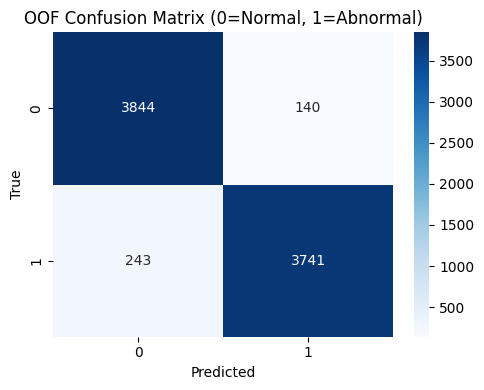

In [7]:
oof_labels = train_df["label"].values
oof_pred_labels = labels_from_probs(oof_preds)

print("\n========== OOF Performance ==========")
print("OOF Accuracy:", accuracy_score(oof_labels, oof_pred_labels))
print("OOF ROC AUC :", roc_auc_score(oof_labels, oof_preds))
print(classification_report(oof_labels, oof_pred_labels, digits=4))

cm = confusion_matrix(oof_labels, oof_pred_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("OOF Confusion Matrix (0=Normal, 1=Abnormal)")
plt.tight_layout()
plt.show()


# Section 7 – Ensemble + TTA on holdout + threshold tuning

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Loaded best_fold_1.pth
Loaded best_fold_2.pth
Loaded best_fold_3.pth
Loaded best_fold_4.pth
Loaded best_fold_5.pth

Best threshold on holdout: 0.425 (weighted F1=0.9548)

===== ENSEMBLE + TTA HOLDOUT PERFORMANCE =====
Accuracy: 0.9548532731376975
ROC AUC : 0.9908432654433909
              precision    recall  f1-score   support

           0     0.9786    0.9300    0.9537       443
           1     0.9333    0.9797    0.9559       443

    accuracy                         0.9549       886
   macro avg     0.9560    0.9549    0.9548       886
weighted avg     0.9560    0.9549    0.9548       886



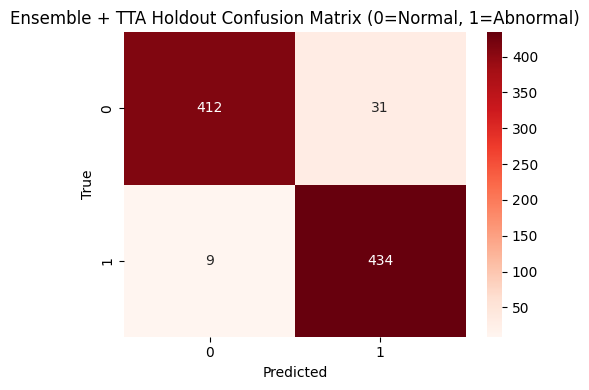

In [8]:
model_paths = [f"best_fold_{i}.pth" for i in range(1, n_folds + 1)]

def create_model_infer():
    backbone = timm.create_model(
        "tf_efficientnet_b3_ns",
        pretrained=False,
        num_classes=0,
        global_pool="avg"
    )
    in_features = backbone.num_features
    head = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 1)
    )
    model = nn.Sequential(backbone, head)
    return model.to(device)

def load_models(paths):
    models = []
    for p in paths:
        m = create_model_infer()
        state = torch.load(p, map_location="cpu")
        m.load_state_dict(state)
        m.eval()
        m.to(device)
        print(f"Loaded {p}")
        models.append(m)
    return models

models_ens = load_models(model_paths)

val_aug_simple = A.Compose([A.Normalize()])

class CTBinaryHoldoutDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        label = int(row["label"])
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = val_aug_simple(image=img)["image"]
        img = np.stack([img, img, img], axis=-1).astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), torch.tensor(label)

def ensemble_tta_predict(models, loader):
    all_probs = []

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            model_probs = []

            for m in models:
                logits1 = m(imgs)
                if logits1.ndim > 2:
                    logits1 = logits1.view(-1, 1)
                p1 = torch.sigmoid(logits1)

                logits2 = m(imgs.flip(-1))
                if logits2.ndim > 2:
                    logits2 = logits2.view(-1, 1)
                p2 = torch.sigmoid(logits2)

                p = (p1 + p2) / 2.0
                model_probs.append(p.detach().cpu().numpy().ravel())

            model_probs = np.stack(model_probs, axis=0).mean(axis=0)
            all_probs.append(model_probs)

    return np.concatenate(all_probs)

hold_ds = CTBinaryHoldoutDataset(holdout_df)
hold_loader = DataLoader(hold_ds, batch_size=32, shuffle=False, num_workers=0)

hold_probs = ensemble_tta_predict(models_ens, hold_loader)
hold_labels = holdout_df["label"].values

best_thr = 0.5
best_f1 = -1

for thr in np.linspace(0.2, 0.8, 25):
    preds = (hold_probs > thr).astype(int)
    f1 = classification_report(hold_labels, preds, digits=4, output_dict=True)["weighted avg"]["f1-score"]
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"\nBest threshold on holdout: {best_thr:.3f} (weighted F1={best_f1:.4f})")

hold_pred = (hold_probs > best_thr).astype(int)
print("\n===== ENSEMBLE + TTA HOLDOUT PERFORMANCE =====")
print("Accuracy:", accuracy_score(hold_labels, hold_pred))
print("ROC AUC :", roc_auc_score(hold_labels, hold_probs))
print(classification_report(hold_labels, hold_pred, digits=4))

cm = confusion_matrix(hold_labels, hold_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Ensemble + TTA Holdout Confusion Matrix (0=Normal, 1=Abnormal)")
plt.tight_layout()
plt.show()

BEST_THRESHOLD = float(best_thr)


# Section 8 – Production inference helpers

In [9]:
def preprocess_single_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Could not read image: {path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = val_aug_simple(image=img)["image"]
    img = np.stack([img, img, img], axis=-1).astype(np.float32)
    img = np.transpose(img, (2, 0, 1))  # C,H,W
    return torch.tensor(img).unsqueeze(0)  # 1,C,H,W

def ensemble_predict(img_tensor):
    img_tensor = img_tensor.to(device)
    probs = []

    with torch.no_grad():
        for m in models_ens:
            logits1 = m(img_tensor)
            if logits1.ndim > 2:
                logits1 = logits1.view(-1, 1)
            p1 = torch.sigmoid(logits1).cpu().numpy().ravel()[0]

            logits2 = m(img_tensor.flip(-1))
            if logits2.ndim > 2:
                logits2 = logits2.view(-1, 1)
            p2 = torch.sigmoid(logits2).cpu().numpy().ravel()[0]

            probs.append((p1 + p2) / 2.0)

    return float(np.mean(probs))

all_probs = []
all_labels = holdout_df["label"].values

for path in holdout_df["path"]:
    t = preprocess_single_image(path)
    p = ensemble_predict(t)
    all_probs.append(p)

pred_labels = (np.array(all_probs) > BEST_THRESHOLD).astype(int)
print("\n[Production API] Accuracy:", accuracy_score(all_labels, pred_labels))
print(classification_report(all_labels, pred_labels, digits=4))



[Production API] Accuracy: 0.9548532731376975
              precision    recall  f1-score   support

           0     0.9786    0.9300    0.9537       443
           1     0.9333    0.9797    0.9559       443

    accuracy                         0.9549       886
   macro avg     0.9560    0.9549    0.9548       886
weighted avg     0.9560    0.9549    0.9548       886



# ROC CURVE (Holdout)

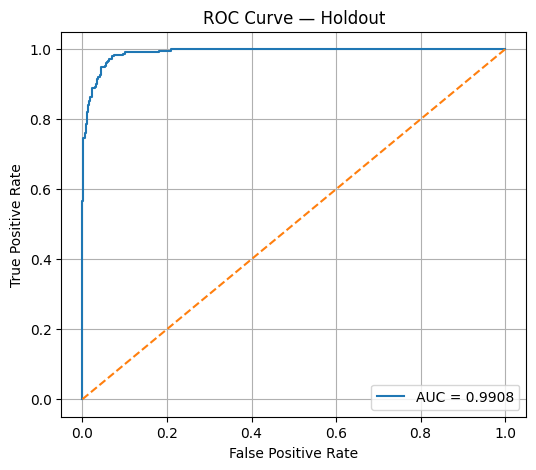

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(hold_labels, hold_probs)
auc = roc_auc_score(hold_labels, hold_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Holdout")
plt.legend()
plt.grid()
plt.show()


# PRECISION–RECALL CURVE (Holdout)

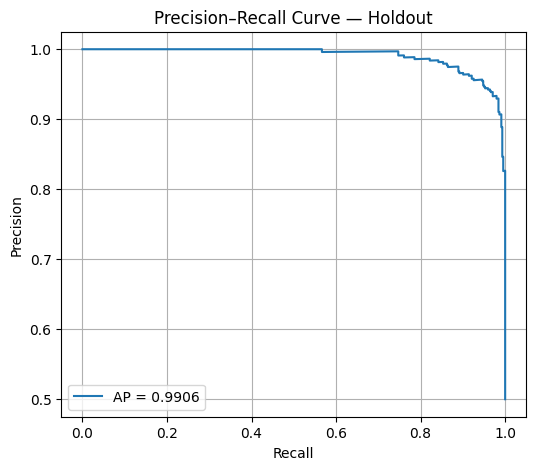

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(hold_labels, hold_probs)
ap = average_precision_score(hold_labels, hold_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Holdout")
plt.legend()
plt.grid()
plt.show()


# PROBABILITY DISTRIBUTION (How confident is the ensemble?)

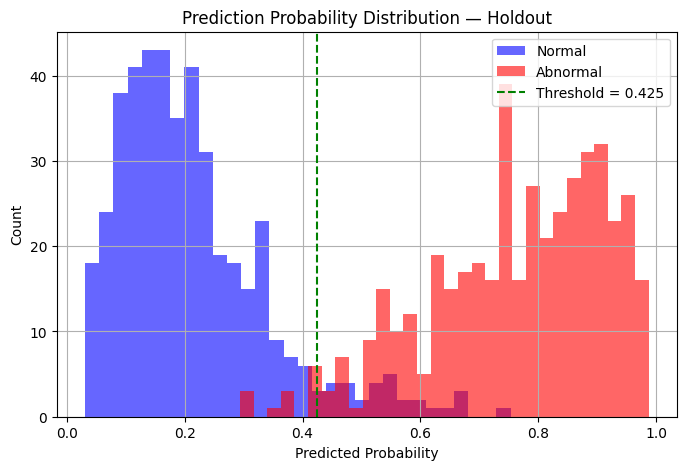

In [13]:
plt.figure(figsize=(8,5))
plt.hist(hold_probs[hold_labels==0], bins=30, alpha=0.6, label="Normal", color="blue")
plt.hist(hold_probs[hold_labels==1], bins=30, alpha=0.6, label="Abnormal", color="red")
plt.axvline(BEST_THRESHOLD, color="green", linestyle="--", label=f"Threshold = {BEST_THRESHOLD:.3f}")
plt.title("Prediction Probability Distribution — Holdout")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()


<div style="border:1px solid #ccc; border-radius:10px; padding:20px;">

<h2 style="text-align:center;">🧠 Stroke CT Classifier — Model Evaluation</h2>

---

## 📊 Overall Performance
<div style="border:1px solid #ddd; border-radius:10px; padding:15px;">

- **Accuracy:** 95.49%  
- **ROC-AUC:** 0.9908  
- **Best Decision Threshold:** 0.425 (optimized for highest F1-score)

</div>

---

## 📚 Class-wise Metrics
<div style="border:1px solid #ddd; border-radius:10px; padding:15px;">

<table>
<tr>
    <th>Class</th>
    <th>Description</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
    <th>Support</th>
</tr>
<tr>
    <td>0</td>
    <td>Normal</td>
    <td>0.9786</td>
    <td>0.9300</td>
    <td>0.9537</td>
    <td>443</td>
</tr>
<tr>
    <td>1</td>
    <td>Abnormal (Stroke)</td>
    <td>0.9333</td>
    <td>0.9797</td>
    <td>0.9559</td>
    <td>443</td>
</tr>
</table>

</div>

---

## ⚙️ Model & Training Configuration
<div style="border:1px solid #ddd; border-radius:10px; padding:15px;">

- **Backbone:** EfficientNet-B3 (Noisy Student)  
- **Approach:** 5-Fold Cross-Validation Ensemble  
- **Inference:** Ensemble of 5 Models + Test-Time Augmentation (TTA)  
- **Loss Function:** Focal Loss (α=0.35, γ=2.5)  
- **Hard Negative Mining:** Applied at Epoch 6  
- **Input:** 384×384 Grayscale CT Slice  
- **Preprocessing:** Albumentations Normalize + Resize  

</div>

</div>
